## Joining Work Zones to 511NY Data
### The work zones we created from the Street Closures data set include an important attribute which is the 'length'. In order to use this attribute in clustering we attempt to join the work zones data to the 511NY events data set.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

import shapely
# from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt

pd.set_option("display.min_rows", 100)

## Importing Data

In [2]:
# reading street closures
wz = pd.read_csv('../data/cleaned_data/wz_subset.csv', parse_dates=['created_date', 'closed_date'],
                usecols=['wz_id', 'created_date', 'closed_date', 'bounding_geometry'])#.rename(columns={'bounding_geometry':'geometry'})

# preparing the geometry column
wz['bounding_geometry'] = wz['bounding_geometry'].apply(wkt.loads)

# convert to geodataframe
gdf_wz = gpd.GeoDataFrame(wz, crs='EPSG:2263', 
                             geometry='bounding_geometry')

gdf_wz.head(2)

,wz_id,created_date,closed_date,bounding_geometry
0,0_0,2017-02-02,2018-01-01,"LINESTRING (985479.756 205496.239, 985088.432 ..."
1,1001_0,2017-10-27,2017-11-15,"LINESTRING (985410.519 204937.101, 985199.934 ..."


In [3]:
gdf_wz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2934 entries, 0 to 2933
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   wz_id              2934 non-null   object        
 1   created_date       2934 non-null   datetime64[ns]
 2   closed_date        2934 non-null   datetime64[ns]
 3   bounding_geometry  2934 non-null   geometry      
dtypes: datetime64[ns](2), geometry(1), object(1)
memory usage: 91.8+ KB


In [4]:
# reading 511
_511 = pd.read_csv('../data/cleaned_data/511_crash_lion_processed_0630.csv', parse_dates=['create_time', 'close_time'], 
                  usecols=['event_id', 'create_time', 'close_time', 'geometry'])

# preparing the geometry column
_511['geometry'] = _511['geometry'].apply(wkt.loads)

# convert to geodataframe
gdf_511 = gpd.GeoDataFrame(_511, crs='EPSG:4326', 
                             geometry=_511.geometry)
print(type(gdf_511))
gdf_511.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>


,event_id,create_time,close_time,geometry
0,5,2019-09-30 22:34:00,2019-10-01 05:33:00,POINT (-73.97128 40.74429)
1,8,2019-09-30 19:12:00,2019-10-01 05:29:00,POINT (-73.94539 40.84190)
2,9,2019-09-29 19:47:00,2019-09-30 05:14:00,POINT (-73.94539 40.84190)


In [5]:
# convert geometry column from lat/lon to feet
gdf_511 = gdf_511.to_crs('EPSG:2263')
gdf_511.head(3)

,event_id,create_time,close_time,geometry
0,5,2019-09-30 22:34:00,2019-10-01 05:33:00,POINT (992209.016 210443.803)
1,8,2019-09-30 19:12:00,2019-10-01 05:29:00,POINT (999359.416 246008.497)
2,9,2019-09-29 19:47:00,2019-09-30 05:14:00,POINT (999359.416 246008.497)


## Time Filtration

In [6]:
gdf_511.create_time.min()

Timestamp('2016-12-30 14:39:00')

In [7]:
gdf_511.create_time.max()

Timestamp('2019-09-30 23:12:00')

In [8]:
gdf_wz.created_date.min()

Timestamp('2017-02-02 00:00:00')

In [9]:
gdf_wz.created_date.max()

Timestamp('2020-02-20 00:00:00')

In [10]:
gdf_511.shape

(20717, 4)

In [11]:
gdf_wz.shape

(2934, 4)

In [12]:
# filtering the 511 events that happened after the minimum street closure creation date
gdf_511 = gdf_511[(gdf_511.create_time >= '2017-02-03')]
print(f'{gdf_511.shape[0]} 511-events left after time filteration ')

20115 511-events left after time filteration 


In [13]:
# dropping street closure that started after the max creation time in the 511 
gdf_wz = gdf_wz[gdf_wz.created_date <= '2019-09-30']
print(f'{gdf_wz.shape[0]} work zones left after time filteration ')

2700 work zones left after time filteration 


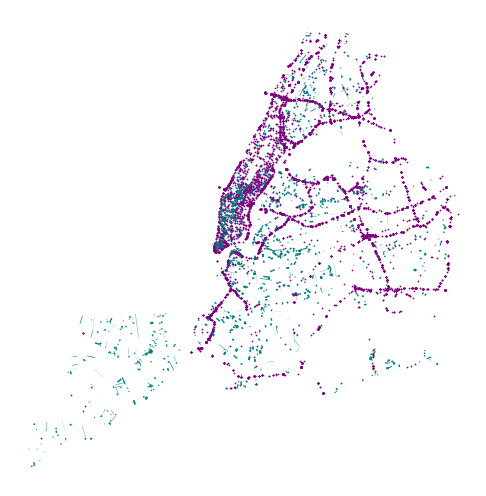

In [14]:
fig, ax = plt.subplots(1,1, figsize=(13,7))
gdf_wz.plot(ax=ax, color='teal')
gdf_511.plot(ax=ax, markersize=.5, color='purple')
plt.axis('off')
plt.tight_layout()


### In order to know which work zone each 511 event belong to, we will perform both a spatial and a temporal join.
### Spatial Join

Some work zones are the result of one street segment closures (linestring geometry), while others are the result of multiple segment closures (multilinestring geometry). To perform a spatial join between the 511 events (point geometries) and the work zones we will need to make sure that all the work zones have a polygon geometry. For that we will use the bouding geometry column which is the minimum rotated rectangle surrounding a work zone (refer to sc_02_EDA notebook). While, the minimum rotated rectangle of a multilinestring is a polygon, that of a linestring is a linestring. To account for that we will add a buffer zone. The buffer radius was based on half a Manhattan standard block width.

In [15]:
# Applying a buffer zone
gdf_wz['buffer_geometry']= gdf_wz.bounding_geometry.buffer(130)
gdf_wz.head(2)

,wz_id,created_date,closed_date,bounding_geometry,buffer_geometry
0,0_0,2017-02-02,2018-01-01,"LINESTRING (985479.756 205496.239, 985088.432 ...","POLYGON ((985017.912 205639.719, 985007.547 20..."
1,1001_0,2017-10-27,2017-11-15,"LINESTRING (985410.519 204937.101, 985199.934 ...","POLYGON ((985129.622 204963.169, 985119.243 20..."


In [16]:
# assigning the buffer_geometry as the geometry column
gdf_wz = gpd.GeoDataFrame(gdf_wz, geometry='buffer_geometry', crs='EPSG:2263')
print(gdf_wz.crs)
gdf_wz.info()

EPSG:2263
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2700 entries, 0 to 2933
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   wz_id              2700 non-null   object        
 1   created_date       2700 non-null   datetime64[ns]
 2   closed_date        2700 non-null   datetime64[ns]
 3   bounding_geometry  2700 non-null   geometry      
 4   buffer_geometry    2700 non-null   geometry      
dtypes: datetime64[ns](2), geometry(2), object(1)
memory usage: 126.6+ KB


In [17]:
# spatially joining 511 points to work zones polygons
sj = gpd.sjoin(gdf_511, gdf_wz, op='within')
sj.shape

(4798, 9)

In [18]:
sj.reset_index(inplace=True, drop=True)
sj.head()

,event_id,create_time,close_time,geometry,index_right,wz_id,created_date,closed_date,bounding_geometry
0,10,2019-09-29 18:01:00,2019-09-29 18:17:00,POINT (982885.494 196403.559),48,1061_0,2017-11-11,2017-11-14,"POLYGON ((982678.310 196323.416, 982978.871 19..."
1,148,2019-09-14 20:14:00,2019-09-15 02:16:00,POINT (982653.523 196473.807),48,1061_0,2017-11-11,2017-11-14,"POLYGON ((982678.310 196323.416, 982978.871 19..."
2,1119,2019-03-16 18:01:00,2019-03-16 18:30:00,POINT (982905.341 196383.495),48,1061_0,2017-11-11,2017-11-14,"POLYGON ((982678.310 196323.416, 982978.871 19..."
3,5026,2018-03-31 23:00:00,2018-04-01 00:15:00,POINT (982907.169 196381.647),48,1061_0,2017-11-11,2017-11-14,"POLYGON ((982678.310 196323.416, 982978.871 19..."
4,7051,2017-08-30 17:42:00,2017-08-31 00:11:00,POINT (983053.692 196313.118),48,1061_0,2017-11-11,2017-11-14,"POLYGON ((982678.310 196323.416, 982978.871 19..."


In [19]:
sj.event_id.value_counts()

23193    13
19706    12
20262    12
19464     9
19526     9
1758      9
6715      9
354       9
20000     9
2290      8
3635      8
7420      8
7376      8
10        8
622       8
6784      8
5772      8
2805      8
5863      8
1023      8
6066      8
4290      7
2292      7
8221      7
1656      7
5026      7
23601     7
1119      7
922       7
4169      6
         ..
2799      1
2843      1
25326     1
734       1
4828      1
726       1
4820      1
2771      1
6865      1
2835      1
4892      1
23385     1
9014      1
25228     1
2891      1
838       1
2883      1
834       1
830       1
19255     1
818       1
798       1
6953      1
2855      1
25382     1
15141     1
4900      1
25693     1
2847      1
23834     1
Name: event_id, Length: 3185, dtype: int64

In [20]:
sj[sj.event_id == 13769]

,event_id,create_time,close_time,geometry,index_right,wz_id,created_date,closed_date,bounding_geometry
2670,13769,2017-04-28 04:02:00,2017-04-28 05:17:00,POINT (1012312.552 246819.613),999,2221_0,2018-09-13,2018-12-11,"POLYGON ((1011439.842 244765.955, 1012321.751 ..."


From the spatial join result above we notice the same 511 event id joined to multiple work zone ids. Next step we will need to check which of these overlap temporally.

In [21]:
sj.wz_id.value_counts()

664_0     694
1679_0    159
2028_0    130
3587_0    100
2880_0    100
1937_0     92
1984_0     90
963_0      88
2250_0     67
3346_0     67
2016_0     62
2049_0     62
1991_0     61
3634_0     51
816_0      50
688_0      50
2345_0     50
3007_0     48
909_0      46
943_0      46
977_0      46
1024_0     44
588_0      44
1680_0     42
223_0      42
2285_0     40
1843_0     39
1472_0     36
1191_0     36
477_0      35
         ... 
3244_0      1
496_0       1
3501_0      1
2679_0      1
1498_0      1
2767_0      1
3177_0      1
2564_0      1
3370_0      1
3082_0      1
2443_0      1
3338_0      1
2821_0      1
232_0       1
3180_0      1
651_0       1
2349_0      1
1931_0      1
999_0       1
3303_0      1
3218_0      1
2554_0      1
2287_0      1
1752_0      1
722_0       1
3264_0      1
2961_0      1
3085_0      1
1265_0      1
2380_0      1
Name: wz_id, Length: 736, dtype: int64

### Temporal Join

In [22]:
wz_id_2221_0 = sj[sj.wz_id == '477_0']
wz_id_2221_0.reset_index(inplace=True, drop=True)
wz_id_2221_0

,event_id,create_time,close_time,geometry,index_right,wz_id,created_date,closed_date,bounding_geometry
0,14386,2019-09-24 10:26:00,2019-09-24 15:52:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
1,14451,2019-09-18 08:43:00,2019-09-18 15:32:00,POINT (1032883.701 200142.887),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
2,14681,2019-08-23 10:29:00,2019-08-23 15:14:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
3,14942,2019-07-26 10:55:00,2019-07-26 16:02:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
4,15086,2019-07-11 01:11:00,2019-07-11 05:07:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
5,15266,2019-03-20 09:08:00,2019-03-20 14:10:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
6,15267,2019-03-20 09:07:00,2019-03-20 14:09:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
7,15427,2019-02-27 11:56:00,2019-02-27 15:09:00,POINT (1032898.653 200235.297),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
8,15450,2019-02-25 10:01:00,2019-02-25 17:05:00,POINT (1032916.403 200115.080),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."
9,15583,2019-01-29 00:58:00,2019-01-29 05:48:00,POINT (1032966.789 200131.787),2504,477_0,2017-07-10,2017-07-20,"LINESTRING (1032907.783 200112.512, 1033113.29..."


In [23]:
wz_id_2221_0.iloc[0].create_time > wz_id_2221_0.iloc[0].created_date


True

In [24]:
retained_rows = []
for i, row in wz_id_2221_0.iterrows():
    if (row.create_time >= row.created_date) & (row.close_time <= row.closed_date):
        retained_rows.append(row)
pd.DataFrame(retained_rows)

,event_id,create_time,close_time,geometry,index_right,wz_id,created_date,closed_date,bounding_geometry
30,21157,2017-07-11 22:31:00,2017-07-12 03:57:00,POINT (1032898.653147208 200235.2966726214),2504,477_0,2017-07-10,2017-07-20,LINESTRING (1032907.782770016 200112.511722166...


In [25]:
def sc_511_temporal_join(df):
    retained_rows = []
    for i, row in df.iterrows():
        if (row.create_time >= row.created_date) & (row.close_time <= row.closed_date):
            retained_rows.append(row)
    return pd.DataFrame(retained_rows)

In [26]:
sc_511_temporal_join(wz_id_2221_0)

,event_id,create_time,close_time,geometry,index_right,wz_id,created_date,closed_date,bounding_geometry
30,21157,2017-07-11 22:31:00,2017-07-12 03:57:00,POINT (1032898.653147208 200235.2966726214),2504,477_0,2017-07-10,2017-07-20,LINESTRING (1032907.782770016 200112.511722166...


In [27]:
# temporal join
tj = sj.groupby('wz_id').apply(lambda x: sc_511_temporal_join(x))
tj

event_id         create_time          close_time  \
wz_id                                                           
101_0  2392    8390.0 2017-05-11 17:27:00 2017-05-12 06:07:00   
108_0  1609    1404.0 2019-02-05 18:27:00 2019-02-05 22:23:00   
       1610    4719.0 2018-04-23 00:37:00 2018-04-23 05:16:00   
109_0  2231    7883.0 2017-06-22 00:23:00 2017-06-22 03:15:00   
1103_0 1089    5694.0 2017-12-19 20:36:00 2017-12-20 04:17:00   
       1090    5708.0 2017-12-18 19:50:00 2017-12-19 05:53:00   
       1091    5725.0 2017-12-16 20:40:00 2017-12-17 08:38:00   
       1092    5765.0 2017-12-12 20:50:00 2017-12-13 04:57:00   
       1093    5781.0 2017-12-11 20:04:00 2017-12-12 04:59:00   
       1094    5803.0 2017-12-08 19:47:00 2017-12-09 06:04:00   
       1095    5857.0 2017-12-04 20:44:00 2017-12-05 05:14:00   
1129_0 2687   12483.0 2017-12-11 22:15:00 2017-12-12 03:34:00   
112_0  2388    8600.0 2017-04-24 21:51:00 2017-04-25 05:52:00   
1160_0 2236    5433.0 2018-02-03 01:36:00 2018-02-03 03:54:00   
1191_0 4385   24898.0 2018-01-10 11:38:00 2018-01-10 13:24:00   
1220_0 3685   19573.0 2018-01-07 21:03:00 2018-01-07 21:18:00   
1237_0 3618   19014.0 2018-03-09 00:55:00 2018-03-09 05:17:00   
       3619   19146.0 2018-02-26 13:12:00 2018-02-26 16:15:00   
       3620   19450.0 2018-01-24 09:54:00 2018-01-24 14:22:00   
1238_0 1896    2627.0 2018-10-08 21:16:00 2018-10-09 05:13:00   
1239_0 3640   19464.0 2018-01-23 00:01:00 2018-01-23 07:14:00   
       3641   19526.0 2018-01-16 00:35:00 2018-01-16 06:58:00   
1250_0 822     2098.0 2018-11-16 22:05:00 2018-11-17 04:18:00   
       823     2627.0 2018-10-08 21:16:00 2018-10-09 05:13:00   
       824     3722.0 2018-07-12 21:54:00 2018-07-13 05:31:00   
       825     4677.0 2018-04-25 21:02:00 2018-04-26 05:11:00   
       826     4756.0 2018-04-19 21:15:00 2018-04-20 05:18:00   
       827     4837.0 2018-04-14 01:08:00 2018-04-14 07:56:00   
1276_0 1731    4128.0 2018-06-10 09:01:00 2018-06-10 10:17:00   
1287_0 2677   12093.0 2018-04-01 20:01:00 2018-04-01 21:16:00   
...               ...                 ...                 ...   
435_0  861     6615.0 2017-10-06 22:25:00 2017-10-07 07:21:00   
       862     6633.0 2017-10-06 08:41:00 2017-10-06 15:04:00   
       863     6780.0 2017-09-25 22:59:00 2017-09-26 02:14:00   
       864     6996.0 2017-09-07 22:05:00 2017-09-08 05:10:00   
       865     7006.0 2017-09-06 22:28:00 2017-09-07 05:02:00   
       866     7313.0 2017-08-07 21:11:00 2017-08-08 03:51:00   
       867     7659.0 2017-07-10 05:15:00 2017-07-10 16:26:00   
460_0  4789   25538.0 2017-07-07 19:56:00 2017-07-08 04:49:00   
463_0  2210    4697.0 2018-04-24 01:14:00 2018-04-24 05:11:00   
477_0  3075   21157.0 2017-07-11 22:31:00 2017-07-12 03:57:00   
535_0  2699   13303.0 2017-07-24 05:24:00 2017-07-24 17:04:00   
547_0  1899    6360.0 2017-10-25 07:42:00 2017-10-25 15:06:00   
554_0  4787   25438.0 2017-08-04 18:11:00 2017-08-05 05:30:00   
588_0  1142    7298.0 2017-08-08 19:35:00 2017-08-09 06:44:00   
670_0  2299    7139.0 2017-08-22 19:47:00 2017-08-23 06:57:00   
671_0  4784   25363.0 2017-08-22 19:54:00 2017-08-23 06:57:00   
735_0  1752    6715.0 2017-09-30 23:00:00 2017-10-01 00:16:00   
797_0  4666   25240.0 2017-09-22 14:03:00 2017-09-22 15:19:00   
928_0  2258    6184.0 2017-11-06 01:24:00 2017-11-06 05:05:00   
955_0  2559   12731.0 2017-10-20 08:11:00 2017-10-20 14:05:00   
963_0  3208   20127.0 2017-10-26 07:35:00 2017-10-26 15:05:00   
968_0  2693   12569.0 2017-11-15 19:09:00 2017-11-15 19:18:00   
977_0  4210   25083.0 2017-11-02 23:46:00 2017-11-03 05:11:00   
       4211   25104.0 2017-10-31 23:00:00 2017-11-01 04:04:00   
       4212   25105.0 2017-10-31 22:13:00 2017-11-01 04:32:00   
       4213   25140.0 2017-10-23 22:07:00 2017-10-24 04:04:00   
979_0  3693   20133.0 2017-10-25 20:52:00 2017-10-26 05:13:00   
981_0  3682   19706.0 2017-12-12 00:51:00 2017-12-12 07:10:00   
       3683   20000.0 2017-11-07 01:06:00 2017-1

In [28]:
tj.reset_index(drop=True, inplace=True)
tj.head()

,event_id,create_time,close_time,geometry,index_right,wz_id,created_date,closed_date,bounding_geometry
0,8390.0,2017-05-11 17:27:00,2017-05-12 06:07:00,POINT (993026.9039586252 217002.6853877026),12.0,101_0,2017-04-10,2017-05-22,"POLYGON ((993062.8558910792 216978.5932019235,..."
1,1404.0,2019-02-05 18:27:00,2019-02-05 22:23:00,POINT (982512.2799896719 200533.0467478991),69.0,108_0,2017-04-11,2020-02-23,"POLYGON ((982995.1182535519 200240.2706020192,..."
2,4719.0,2018-04-23 00:37:00,2018-04-23 05:16:00,POINT (982927.1365832693 200280.1765146855),69.0,108_0,2017-04-11,2020-02-23,"POLYGON ((982995.1182535519 200240.2706020192,..."
3,7883.0,2017-06-22 00:23:00,2017-06-22 03:15:00,POINT (992908.5994638029 212606.0464512985),78.0,109_0,2017-04-12,2017-08-29,"POLYGON ((992211.8804318563 212931.9705972746,..."
4,5694.0,2017-12-19 20:36:00,2017-12-20 04:17:00,POINT (981313.0888129045 194918.5111898552),83.0,1103_0,2017-11-20,2017-12-31,LINESTRING (981153.9885598836 194954.902279754...


In [29]:
tj.shape

(272, 9)

In [30]:
tj.event_id.nunique()

263

In [43]:
merge_att = tj.groupby('event_id').agg({'wz_id': 'first'}).reset_index()
merge_att.head(2)

,event_id,wz_id
0,66.0,3362_0
1,359.0,3430_0


In [44]:
merge_att.shape

(263, 2)

In [45]:
df_wz = pd.read_csv('../data/cleaned_data/wz_crashCount.csv')
df_wz.head(2)

,wz_id,segmentid,created_date,closed_date,created_season,closed_season,duration_days,purpose,geometry,length_ft,bounding_geometry,bounding_area,buffer_geometry,crash_list,crash_count
0,0_0,[32594],2017-02-02,2018-01-01,winter,winter,333,"[""['Occupancy Of Roadway As Stipulated']""]",LINESTRING (985479.7560875559 205496.239369042...,465.818036,LINESTRING (985479.7560875559 205496.239369042...,0.0,"POLYGON ((984600.214479992 204992.8578009224, ...","[3666626, 3784199, 3636121, 3655994, 3743386, ...",132
1,1001_0,[32568],2017-10-27,2017-11-15,fall,fall,19,"[""['Occupancy Of Roadway As Stipulated']""]",LINESTRING (985410.5192044964 204937.101001921...,250.365126,LINESTRING (985410.5192044964 204937.101001921...,0.0,"POLYGON ((984713.1585457764 204315.5136725391,...","[3782864, 3784636, 3786322, 3780986, 3784142]",5


In [47]:
df_wz = merge_att.merge(df_wz, on='wz_id')
df_wz.head(2)

,event_id,wz_id,segmentid,created_date,closed_date,created_season,closed_season,duration_days,purpose,geometry,length_ft,bounding_geometry,bounding_area,buffer_geometry,crash_list,crash_count
0,66.0,3362_0,[165961 165962],2019-07-13,2019-11-10,summer,fall,120,"[""['Major Installations - Gas-Protected', 'Occ...","POLYGON ((991924.5146984088 228546.6535348285,...",450.871958,"POLYGON ((991924.5146984088 228546.6535348285,...",194.667062,"POLYGON ((991137.248393776 228982.7862733267, ...","[4190526, 4212117, 4183045, 4237583, 4213385, ...",91
1,511.0,3362_0,[165961 165962],2019-07-13,2019-11-10,summer,fall,120,"[""['Major Installations - Gas-Protected', 'Occ...","POLYGON ((991924.5146984088 228546.6535348285,...",450.871958,"POLYGON ((991924.5146984088 228546.6535348285,...",194.667062,"POLYGON ((991137.248393776 228982.7862733267, ...","[4190526, 4212117, 4183045, 4237583, 4213385, ...",91


In [48]:
df_wz.to_csv('../data/cleaned_data/wz_crashCount_511-id.csv', index=False)

In [50]:
df_wz[['event_id', 'wz_id', 'length_ft', 'crash_count']].to_csv('../data/cleaned_data/clustering_2_att.csv', index=False)